In [5]:
import os


In [2]:
os.chdir('/content/drive/MyDrive/NLP_Sentiment Analysis')

In [3]:
print(os.getcwd())


/content/drive/MyDrive/NLP_Sentiment Analysis


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


=== Sentiment Analysis Pipeline Starting ===
Loaded 10980 tweets.
Generating EDA plots...


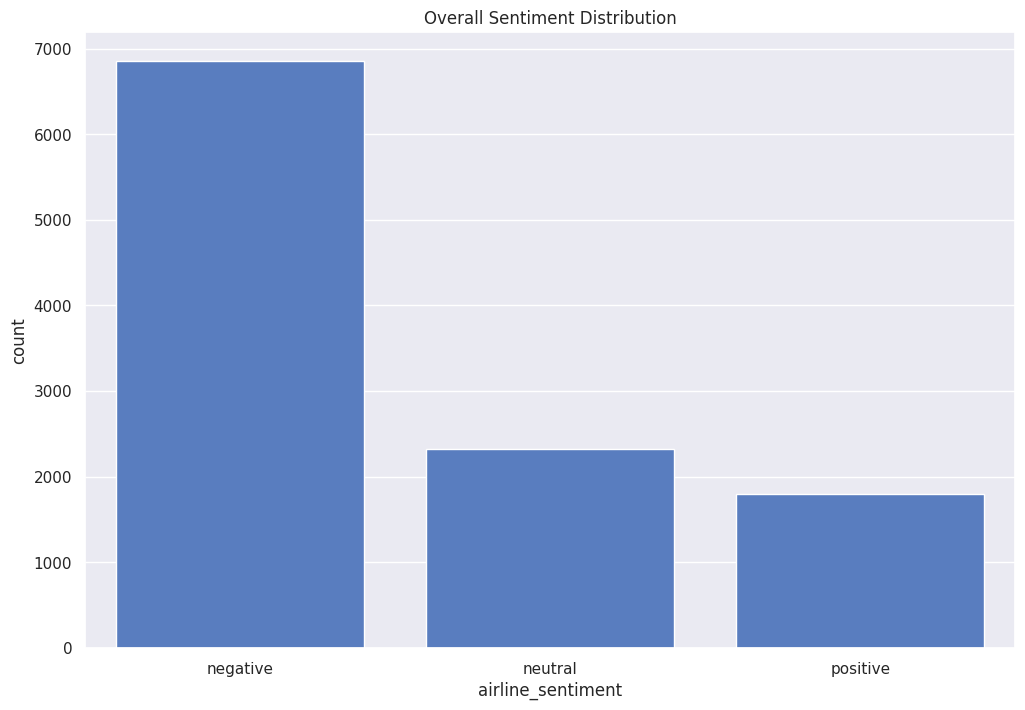

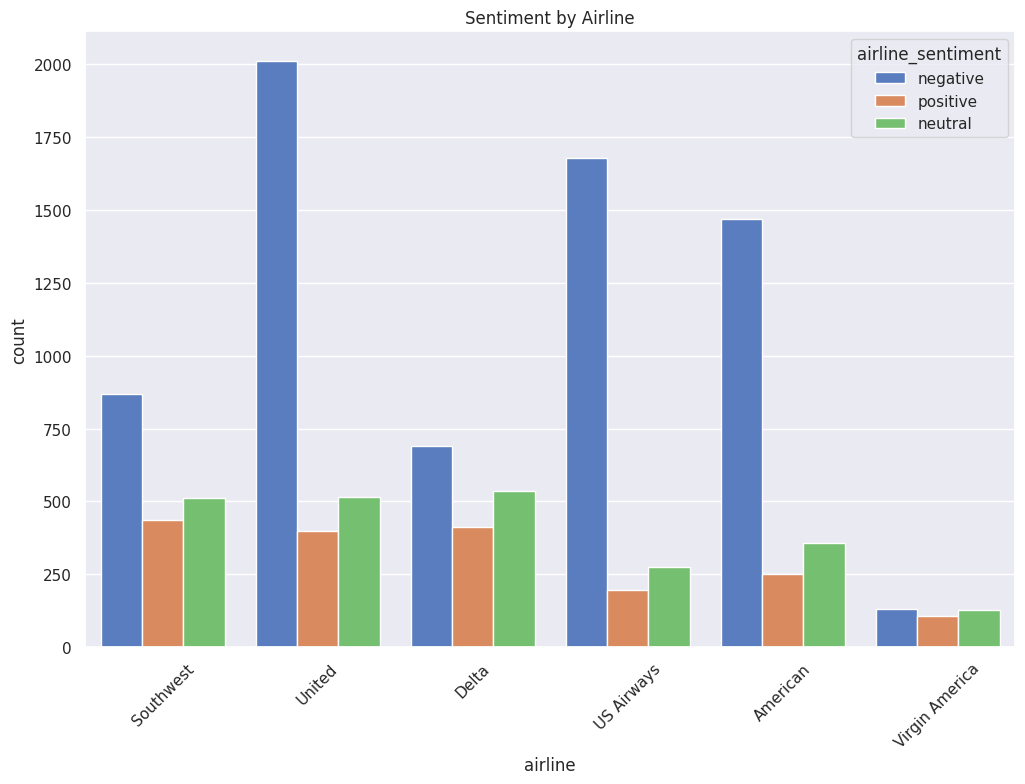

Cleaning text data...
Training Naive Bayes...
Training SVM (LinearSVC)...
Training Logistic Regression...

=== SENTIMENT ANALYSIS EVALUATION REPORT ===

Naive Bayes Accuracy: 0.7136
SVM Accuracy: 0.7709
Logistic Regression Accuracy: 0.7687

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.99      0.82      1356
     neutral       0.73      0.21      0.32       458
    positive       0.92      0.34      0.49       382

    accuracy                           0.71      2196
   macro avg       0.78      0.51      0.55      2196
weighted avg       0.74      0.71      0.66      2196

SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.90      0.86      1356
     neutral       0.59      0.51      0.55       458
    positive       0.76      0.61      0.68       382

    accuracy                           0.77      2196
   macro avg       0.73      0.68      0.70 

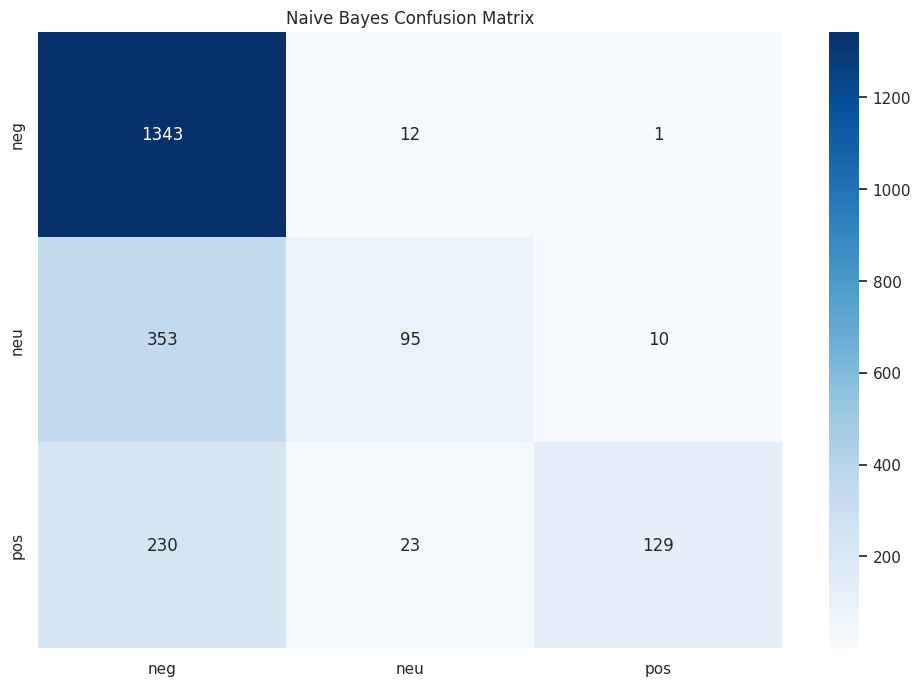

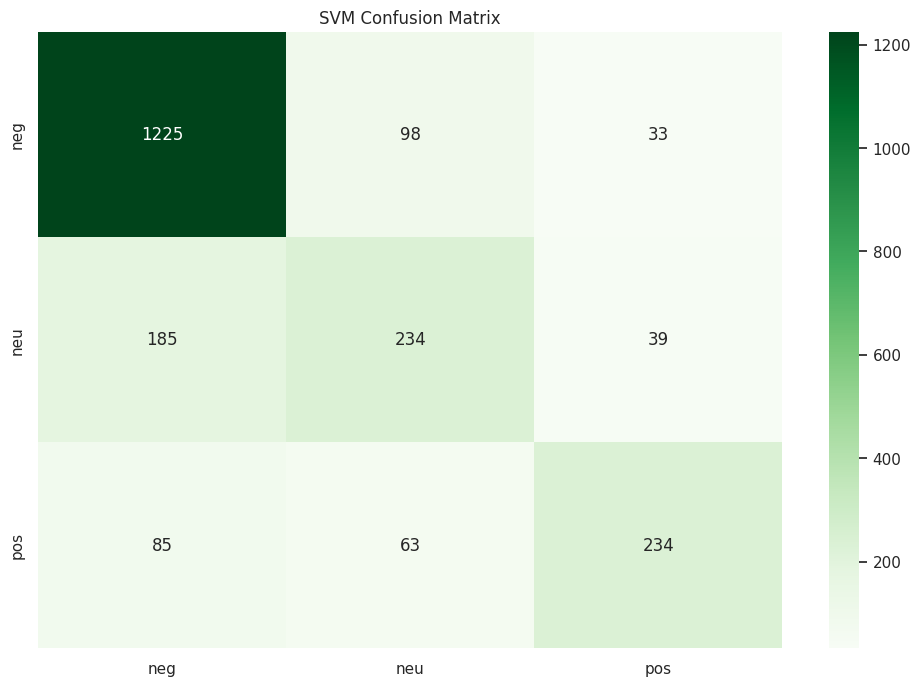

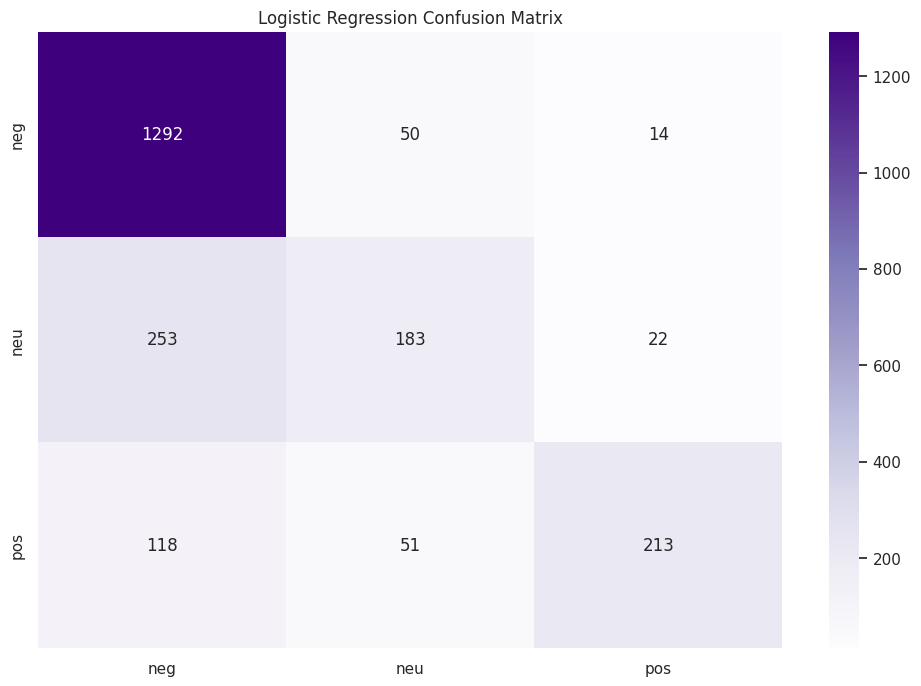

/tmp/ipython-input-1239655753.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='deep')


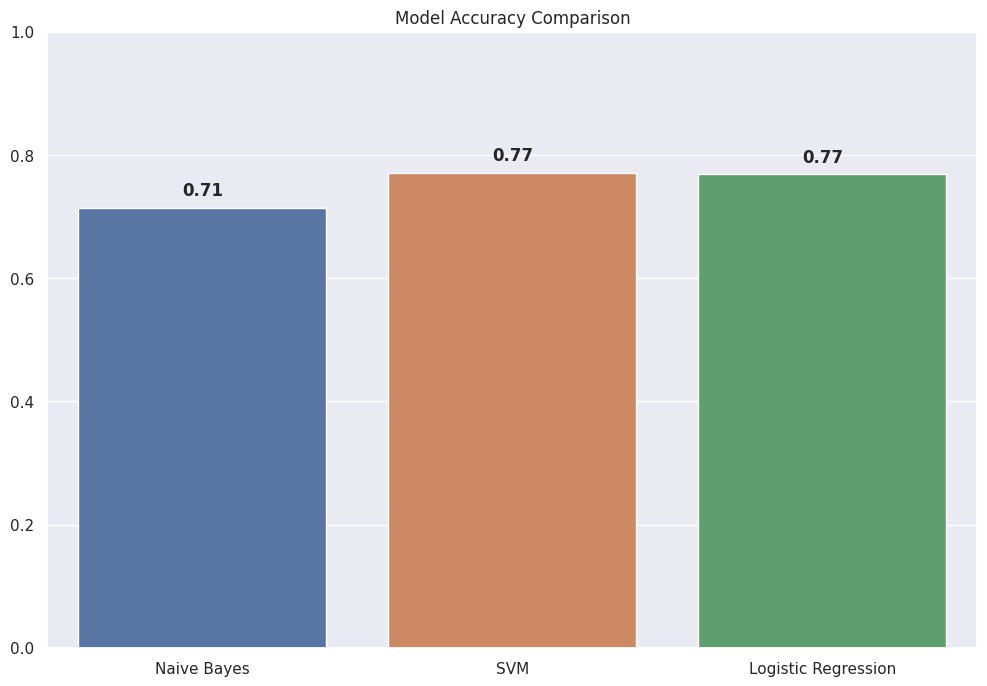


--- Model Selection ---
Selecting SVM as the best model (Accuracy: 0.7709)
Saving best model and vectorizer...
=== Pipeline Completed Successfully ===
Outputs generated: model_evaluation_report.txt, 6 PNG plots, sentiment_model.joblib (SVM), and tfidf_vectorizer.joblib.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

# --- NLP PREPROCESSING UTILITIES ---
# Download necessary NLTK data
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

def clean_text(text):
    """
    Cleans the input text by:
    - Lowercasing
    - Removing URLs
    - Removing mentions (@user)
    - Removing punctuation
    - Removing numbers
    - Removing stop words
    - Lemmatization
    """
    # Lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

# --- MAIN ANALYSIS PIPELINE ---

# Set aesthetic style
sns.set_theme(style="darkgrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

def run_pipeline():
    print("=== Sentiment Analysis Pipeline Starting ===")

    # Load Data
    data_path = 'train_test/twitter.csv'
    if not os.path.exists(data_path):
        print(f"Error: Dataset not found at {data_path}")
        return

    df = pd.read_csv(data_path)
    print(f"Loaded {len(df)} tweets.")

    # EDA: Exploratory Data Analysis
    print("Generating EDA plots...")
    plt.figure()
    sns.countplot(x='airline_sentiment', data=df, order=['negative', 'neutral', 'positive'])
    plt.title('Overall Sentiment Distribution')
    plt.savefig('sentiment_distribution.png')
    plt.show() # Display plot instantly

    plt.figure()
    sns.countplot(x='airline', hue='airline_sentiment', data=df)
    plt.title('Sentiment by Airline')
    plt.xticks(rotation=45)
    plt.savefig('sentiment_by_airline.png')
    plt.show() # Display plot instantly

    # Preprocessing
    print("Cleaning text data...")
    df['clean_text'] = df['text'].apply(clean_text)

    # Feature Engineering
    tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    X = tfidf.fit_transform(df['clean_text'])
    y = df['airline_sentiment']

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model 1: Naive Bayes
    print("Training Naive Bayes...")
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    nb_pred = nb.predict(X_test)
    nb_acc = accuracy_score(y_test, nb_pred)

    # Model 2: SVM (LinearSVC)
    print("Training SVM (LinearSVC)...")
    svm = LinearSVC(max_iter=1000)
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    svm_acc = accuracy_score(y_test, svm_pred)

    # Model 3: Logistic Regression
    print("Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_acc = accuracy_score(y_test, lr_pred)

    # Results Documentation
    report_text = f"=== SENTIMENT ANALYSIS EVALUATION REPORT ===\n\n"
    report_text += f"Naive Bayes Accuracy: {nb_acc:.4f}\n"
    report_text += f"SVM Accuracy: {svm_acc:.4f}\n"
    report_text += f"Logistic Regression Accuracy: {lr_acc:.4f}\n\n"
    report_text += "Naive Bayes Classification Report:\n"
    report_text += classification_report(y_test, nb_pred)
    report_text += "\nSVM Classification Report:\n"
    report_text += classification_report(y_test, svm_pred)
    report_text += "\nLogistic Regression Classification Report:\n"
    report_text += classification_report(y_test, lr_pred)

    # PRINT RESULTS TO TERMINAL (Like a Notebook)
    print("\n" + report_text)

    # Save to file
    with open('model_evaluation_report.txt', 'w') as f:
        f.write(report_text)

    # Confusion Matrices
    print("Generating Confusion Matrices...")
    plt.figure()
    cm_nb = confusion_matrix(y_test, nb_pred)
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
                xticklabels=['neg', 'neu', 'pos'], yticklabels=['neg', 'neu', 'pos'])
    plt.title('Naive Bayes Confusion Matrix')
    plt.savefig('cm_naive_bayes.png')
    plt.show() # Display plot instantly

    plt.figure()
    cm_svm = confusion_matrix(y_test, svm_pred)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['neg', 'neu', 'pos'], yticklabels=['neg', 'neu', 'pos'])
    plt.title('SVM Confusion Matrix')
    plt.savefig('cm_svm.png')
    plt.show() # Display plot instantly

    plt.figure()
    cm_lr = confusion_matrix(y_test, lr_pred)
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples',
                xticklabels=['neg', 'neu', 'pos'], yticklabels=['neg', 'neu', 'pos'])
    plt.title('Logistic Regression Confusion Matrix')
    plt.savefig('cm_logistic_regression.png')
    plt.show() # Display plot instantly

    # Accuracy Comparison Plot
    plt.figure()
    models = ['Naive Bayes', 'SVM', 'Logistic Regression']
    accuracies = [nb_acc, svm_acc, lr_acc]
    sns.barplot(x=models, y=accuracies, palette='deep')
    plt.ylim(0, 1.0)
    plt.title('Model Accuracy Comparison')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    plt.savefig('model_accuracy_comparison.png')
    plt.show() # Display plot instantly

    # Automatic Model Selection for Demo
    print("\n--- Model Selection ---")
    results = {
        "Naive Bayes": (nb, nb_acc),
        "SVM": (svm, svm_acc),
        "Logistic Regression": (lr, lr_acc)
    }

    best_name = max(results, key=lambda k: results[k][1])
    best_model, best_acc = results[best_name]

    print(f"Selecting {best_name} as the best model (Accuracy: {best_acc:.4f})")
    print("Saving best model and vectorizer...")
    joblib.dump(best_model, 'sentiment_model.joblib')
    joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

    print("=== Pipeline Completed Successfully ===")
    print(f"Outputs generated: model_evaluation_report.txt, 6 PNG plots, sentiment_model.joblib ({best_name}), and tfidf_vectorizer.joblib.")

if __name__ == "__main__":
    run_pipeline()
